In [1]:
%matplotlib inline
import os
import torch
from torch import nn
import d2l_torch as d2l
import json
import datetime


![经验](draw/fine_tuning.png)

### jupyter只能跟踪主进程，没法跟踪子进程。

In [2]:
d2l.DATA_HUB['SNLI'] = (
    'https://nlp.stanford.edu/projects/snli/snli_1.0.zip',
    '9fcde07509c7e87ec61c640c1b2753d9041758e4')

data_dir = "..\data\snli_1.0"

In [3]:
d2l.DATA_HUB['bert.base'] = (d2l.DATA_URL + 'bert.base.torch.zip',
                             '225d66f04cae318b841a13d32af3acc165f253ac')
d2l.DATA_HUB['bert.small'] = (d2l.DATA_URL + 'bert.small.torch.zip',
                              'c72329e68a732bef0452e4b96a1c341c8910f81f')

In [4]:
def load_pretrained_model(pretrained_model, num_hiddens, ffn_num_hiddens,
                          num_heads, num_blks, dropout, max_len, devices):
    data_dir = d2l.download_extract(pretrained_model)
    # Define an empty vocabulary to load the predefined vocabulary
    vocab = d2l.Vocab()
    vocab.idx_to_token = json.load(open(os.path.join(data_dir, 'vocab.json')))
    vocab.token_to_idx = {token: idx for idx, token in enumerate(
        vocab.idx_to_token)}
    bert = d2l.BERTModel(
        len(vocab), num_hiddens, ffn_num_hiddens=ffn_num_hiddens, num_heads=4,
        num_blks=2, dropout=0.2, max_len=max_len)
    # Load pretrained BERT parameters
    bert.load_state_dict(torch.load(os.path.join(data_dir,
                                                 'pretrained.params')))
    return bert, vocab

In [5]:
    devices = d2l.try_all_gpus()
    print('load_pretrained_model start: ', datetime.datetime.now())
    bert, vocab = load_pretrained_model(
        'bert.small', num_hiddens=256, ffn_num_hiddens=512, num_heads=4,
        num_blks=2, dropout=0.1, max_len=512, devices=devices)
    print('load_pretrained_model end: ', datetime.datetime.now())

load_pretrained_model start:  2023-10-03 12:01:22.382007
load_pretrained_model end:  2023-10-03 12:01:23.236521


C:\Users\rongjoker\anaconda3\envs\pandas\lib\site-packages\torch\nn\modules\lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


In [6]:
class SNLIBERTDataset(torch.utils.data.Dataset):
    def __init__(self, dataset, max_len, vocab=None):
        all_premise_hypothesis_tokens = [[
            p_tokens, h_tokens] for p_tokens, h_tokens in zip(
            *[d2l.tokenize([s.lower() for s in sentences])
              for sentences in dataset[:2]])]

        self.labels = torch.tensor(dataset[2])
        self.vocab = vocab
        self.max_len = max_len
        (self.all_token_ids, self.all_segments,
         self.valid_lens) = self._preprocess(all_premise_hypothesis_tokens)
        print('read ' + str(len(self.all_token_ids)) + ' examples')

    def _preprocess(self, all_premise_hypothesis_tokens):
        out = [self._mp_worker(single_premise_hypothesis_tokens) for single_premise_hypothesis_tokens in
               all_premise_hypothesis_tokens]
        all_token_ids = [
            token_ids for token_ids, segments, valid_len in out]
        all_segments = [segments for token_ids, segments, valid_len in out]
        valid_lens = [valid_len for token_ids, segments, valid_len in out]
        return (torch.tensor(all_token_ids, dtype=torch.long),
                torch.tensor(all_segments, dtype=torch.long),
                torch.tensor(valid_lens))

    def _mp_worker(self, premise_hypothesis_tokens):
        p_tokens, h_tokens = premise_hypothesis_tokens
        self._truncate_pair_of_tokens(p_tokens, h_tokens)
        tokens, segments = d2l.get_tokens_and_segments(p_tokens, h_tokens)
        token_ids = self.vocab[tokens] + [self.vocab['<pad>']] \
                    * (self.max_len - len(tokens))
        segments = segments + [0] * (self.max_len - len(segments))
        valid_len = len(tokens)
        return token_ids, segments, valid_len

    def _truncate_pair_of_tokens(self, p_tokens, h_tokens):
        # 为BERT输入中的'<CLS>'、'<SEP>'和'<SEP>'词元保留位置
        while len(p_tokens) + len(h_tokens) > self.max_len - 3:
            if len(p_tokens) > len(h_tokens):
                p_tokens.pop()
            else:
                h_tokens.pop()

    def __getitem__(self, idx):
        return (self.all_token_ids[idx], self.all_segments[idx],
                self.valid_lens[idx]), self.labels[idx]

    def __len__(self):
        return len(self.all_token_ids)

In [7]:
class BERTClassifier(nn.Module):
    def __init__(self, bert):
        super(BERTClassifier, self).__init__()
        self.encoder = bert.encoder
        self.hidden = bert.hidden
        self.output = nn.Linear(256, 3)

    def forward(self, inputs):
        tokens_X, segments_X, valid_lens_x = inputs
        encoded_X = self.encoder(tokens_X, segments_X, valid_lens_x)
        return self.output(self.hidden(encoded_X[:, 0, :]))

In [8]:
def train_bert_fine_tuning(lr= 1e-4, num_epochs=5):
    # 如果出现显存不足错误，请减少“batch_size”。在原始的BERT模型中，max_len=512
    # Reduce `batch_size` if there is an out of memory error. In the original BERT
    # model, `max_len` = 512
    batch_size, max_len, num_workers = 512, 128, d2l.get_dataloader_workers()
    # data_dir = d2l.download_extract('SNLI')
    print('load dataset start: ', datetime.datetime.now())
    train_set = SNLIBERTDataset(d2l.read_snli(data_dir, True), max_len, vocab)
    test_set = SNLIBERTDataset(d2l.read_snli(data_dir, False), max_len, vocab)
    train_iter = torch.utils.data.DataLoader(train_set, batch_size, shuffle=True,
                                             num_workers=num_workers)
    test_iter = torch.utils.data.DataLoader(test_set, batch_size,
                                            num_workers=num_workers)
    print('load dataset end: ', datetime.datetime.now())

    net = BERTClassifier(bert)
    trainer = torch.optim.Adam(net.parameters(), lr=lr)
    loss = nn.CrossEntropyLoss(reduction='none')
    print('train start: ', datetime.datetime.now())
    d2l.train_ch13(net, train_iter, test_iter, loss, trainer, num_epochs,
                   devices)
    print('train end: ', datetime.datetime.now())
    torch.save(net.state_dict(), 'model/nli_bert_small_jupyter.pth')

In [9]:
class SNLIBERTInferData:
    def __init__(self, ss, max_len, vocab=None):
        pp = [sentences[0] for sentences in ss]
        hh = [sentences[1] for sentences in ss]
        kk = [pp, hh]

        premise_hypothesis_tokens = [[
            p_tokens, h_tokens] for p_tokens, h_tokens in zip(
            *[d2l.tokenize([s.lower() for s in sentences])
              for sentences in kk])]
        # print(premise_hypothesis_tokens[0])
        # [['a', 'person', 'on', 'a', 'horse', 'jumps', 'over', 'a', 'broken', 'down', 'airplane', '.'], ['a',
        # 'person', 'is', 'training', 'his', 'horse', 'for', 'a', 'competition', '.']]
        self.vocab = vocab
        self.max_len = max_len
        (self.all_token_ids, self.all_segments,
         self.valid_lens) = self._preprocess(premise_hypothesis_tokens)
        # print(self.all_token_ids[0])
        # print(self.all_segments[0])
        # print(self.valid_lens[0])
        print('read ' + str(len(self.all_token_ids)) + ' examples')

    def _preprocess(self, all_premise_hypothesis_tokens):
        # out = self._mp_worker(all_premise_hypothesis_tokens)
        out = [self._mp_worker(single_premise_hypothesis_tokens) for single_premise_hypothesis_tokens in
               all_premise_hypothesis_tokens]
        # print('out:', type(out))
        all_token_ids = [
            token_ids for token_ids, segments, valid_len in out]
        all_segments = [segments for token_ids, segments, valid_len in out]
        valid_lens = [valid_len for token_ids, segments, valid_len in out]
        return (torch.tensor(all_token_ids, dtype=torch.long, device=d2l.try_gpu()),
                torch.tensor(all_segments, dtype=torch.long, device=d2l.try_gpu()),
                torch.tensor(valid_lens, device=d2l.try_gpu()))

    def _mp_worker(self, single_premise_hypothesis_tokens):
        p_tokens, h_tokens = single_premise_hypothesis_tokens
        self._truncate_pair_of_tokens(p_tokens, h_tokens)
        tokens, segments = d2l.get_tokens_and_segments(p_tokens, h_tokens)
        token_ids = self.vocab[tokens] + [self.vocab['<pad>']] \
                    * (self.max_len - len(tokens))
        segments = segments + [0] * (self.max_len - len(segments))
        valid_len = len(tokens)
        return token_ids, segments, valid_len

    def _truncate_pair_of_tokens(self, p_tokens, h_tokens):
        # 为BERT输入中的'<CLS>'、'<SEP>'和'<SEP>'词元保留位置
        while len(p_tokens) + len(h_tokens) > self.max_len - 3:
            if len(p_tokens) > len(h_tokens):
                p_tokens.pop()
            else:
                h_tokens.pop()

    def __getitem__(self, idx):
        return (self.all_token_ids[idx], self.all_segments[idx],
                self.valid_lens[idx])

    def get_item(self, idx):
        return ([self.all_token_ids[idx]], [self.all_segments[idx]],
                [self.valid_lens[idx]])

    def get_all_entity(self):
        return (self.all_token_ids, self.all_segments,
                self.valid_lens)

    def __len__(self):
        return len(self.all_token_ids)

In [10]:
def infer_test(describe):
    # 如果出现显存不足错误，请减少“batch_size”。在原始的BERT模型中，max_len=512
    # Reduce `batch_size` if there is an out of memory error. In the original BERT
    # model, `max_len` = 512
    # batch_size, max_len, num_workers = 512, 128, d2l.get_dataloader_workers()
    # # data_dir = d2l.download_extract('SNLI')
    # train_set = SNLIBERTDataset(d2l.read_snli(data_dir, True), max_len, vocab)
    # test_set = SNLIBERTDataset(d2l.read_snli(data_dir, False), max_len, vocab)
    # train_iter = torch.utils.data.DataLoader(train_set, batch_size, shuffle=True,
    #                                          num_workers=num_workers)
    # test_iter = torch.utils.data.DataLoader(test_set, batch_size,
    #                                         num_workers=num_workers)

    # 循环前2个
    # ss = [sentences for sentences in describe[:2]]
    # print(ss)

    # for desc in describe:
    #     print(infer_snli_bert(desc[0], desc[1]))
    #     print('---------------------------------')
    # bert, vocab = load_pretrained_model(
    #     'bert.small', num_hiddens=256, ffn_num_hiddens=512, num_heads=4,
    #     num_blks=2, dropout=0.1, max_len=512, devices=d2l.try_all_gpus())
    data = SNLIBERTInferData(ss=describe, max_len=128, vocab=vocab)
    model = BERTClassifier(bert)
    model.load_state_dict(torch.load('model/nli_bert_small_jupyter.pth'))
    model = model.to(d2l.try_gpu())
    model.eval()  # 设置模型为推理模式
    # todo tokens_X, segments_X, valid_lens_x = inputs
    # X[0].shape: torch.Size([512, 128])
    # X[1].shape: torch.Size([512, 128])
    # X[2].shape: torch.Size([512])
    ret = model(data.get_all_entity())

    label = torch.argmax(ret, dim=1)
    ss = [('entailment' if l == 0 else 'contradiction' if l == 1 else 'neutral') for l in label]
    for i,sentence in enumerate(describe):
        print('p:' ,sentence[0])
        print('h:' ,sentence[1])
        print('l:', ss[i])
        print('-----------------------')

    return ss

loss 0.190, train acc 0.929, test acc 0.773
6091.0 examples/sec on [device(type='cuda', index=0)]
train end:  2023-10-03 13:48:00.283389


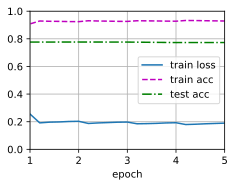

In [13]:
train_bert_fine_tuning(num_epochs=5)

In [14]:
ds = [
    ['我是好人', '我是坏人'],
    ['i am a good people', 'i am a bad people'],
    ['Two women are hugging each other.', 'Two women are showing affection.'],
    ['两个女人拥抱在一起', '两个女人在示爱'],
    ['i am tired', 'i want to sheep'],
    ['i am hungry', 'i starve'],
    ['i am hungry', 'i want to eat meal'],
    ['i am hungry', 'i want to eat meat'],
    ['i want to eat meat', 'i want to eat meal'],
    ['i like gone with the wind', 'i like the character scarlet'],
    ['i like gone with the wind', 'i hate reading'],
    ['i like gone with the wind', 'i also like the shortest history of europe']]
infer_test(ds)

read 12 examples
p: 我是好人
h: 我是坏人
l: entailment
-----------------------
p: i am a good people
h: i am a bad people
l: neutral
-----------------------
p: Two women are hugging each other.
h: Two women are showing affection.
l: entailment
-----------------------
p: 两个女人拥抱在一起
h: 两个女人在示爱
l: entailment
-----------------------
p: i am tired
h: i want to sheep
l: contradiction
-----------------------
p: i am hungry
h: i starve
l: contradiction
-----------------------
p: i am hungry
h: i want to eat meal
l: neutral
-----------------------
p: i am hungry
h: i want to eat meat
l: neutral
-----------------------
p: i want to eat meat
h: i want to eat meal
l: entailment
-----------------------
p: i like gone with the wind
h: i like the character scarlet
l: entailment
-----------------------
p: i like gone with the wind
h: i hate reading
l: contradiction
-----------------------
p: i like gone with the wind
h: i also like the shortest history of europe
l: neutral
-----------------------


['entailment',
 'neutral',
 'entailment',
 'entailment',
 'contradiction',
 'contradiction',
 'neutral',
 'neutral',
 'entailment',
 'entailment',
 'contradiction',
 'neutral']